
---
> **Assignee** <br />
> Name: Theofanopoulos Michail <br />
> Email: mic.theofanopoulos@aueb.gr <br />
> ID: p3352401 <br />
> Course: Machine Learning and Computational Statistics <br />
---

In [341]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.optimize import nnls, minimize
import cvxopt as cx


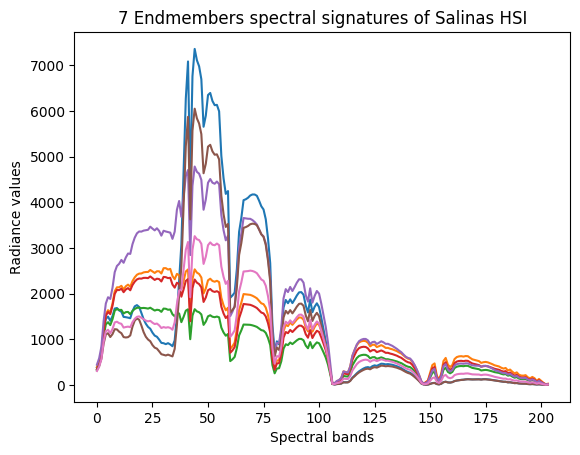

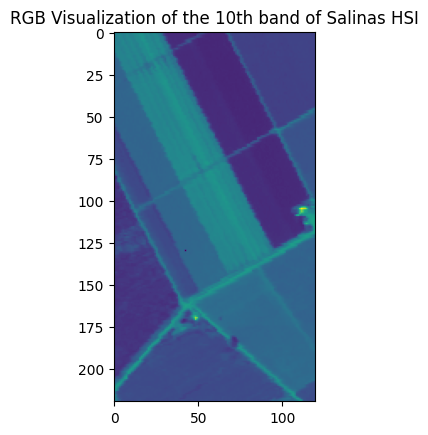

In [310]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

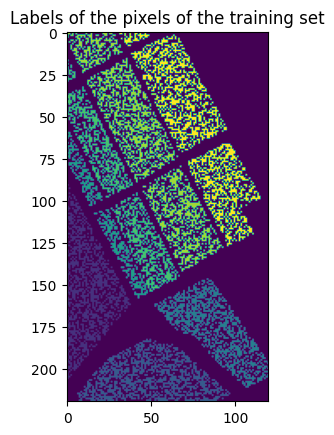

In [311]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

## Spectral Unmixing

In [312]:
# Least Squares estimate with no constraints
def least_squares(X, y):
    theta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    return theta

In [313]:
# Least Squares estimate with sum-to-one constraint
def least_squares_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess
    theta0 = np.ones(n) / n
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, constraints=[constraint], method='SLSQP')
    return result.x

In [314]:
#  Least Squares estimate with non-negativity constraint
def least_squares_nonneg(X, y):
    theta, residuals = nnls(X, y)
    return theta

In [315]:
# Least Squares estimate with non-negativity and sum-to-one constraints
def least_squares_nonneg_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess (uniform positive summing to 1)
    theta0 = np.ones(n) / n
    
    # Bounds: all parameters >= 0
    bounds = [(0, None) for _ in range(n)]
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, bounds=bounds, constraints=[constraint], method='SLSQP')
    return result.x

In [316]:
# Least Squares estimate with non-negativity and sum-to-one constraints
def least_squares_nonneg_sum_to_one_v2(X, y):
    cx.solvers.options['show_progress'] = False

    # Problem dimensions
    n = X.shape[1]

    # Define matrices for quadratic programming
    I = cx.spdiag(cx.matrix([-1.0] * n))  # Non-negativity constraint
    h = cx.matrix([0.0] * n)
    P = cx.matrix(2 * X.T @ X)  # Quadratic term in ||Xθ - y||²
    q = cx.matrix(-2 * X.T @ y)  # Linear term in ||Xθ - y||²
    A = cx.matrix([1.0] * n, (1, n))  # Sum-to-one constraint
    b = cx.matrix([1.0])

    # Solve QP problem
    result = cx.solvers.qp(P, q, G=I, h=h, A=A, b=b)

    return np.array(result['x']).flatten()  # Ensure it returns shape (7,)

In [ ]:
# Lasso estimate
def lasso(X, y):
    clf = linear_model.Lasso(alpha=37, positive=True, fit_intercept=False, max_iter=10000000)
    clf.fit(X, y)
    
    return clf.coef_

In [318]:
# Unmixing function
def unmix_matrix(endmembers, HSI, labels, method="Least Squares"):
    # Find non-zero label indices
    non_zero_indices = np.where(labels != 0)
    num_valid_pixels = len(non_zero_indices[0])
    
    # Get dimensions
    X = endmembers
    n_endmembers = endmembers.shape[1]
    
    # Initialize abundance map to only contain valid pixels
    abundance_map = np.zeros((num_valid_pixels, n_endmembers))
    total_error = 0
    
    # Process only non-zero labeled pixels
    for idx in range(num_valid_pixels):
        i, j = non_zero_indices[0][idx], non_zero_indices[1][idx]
        y = HSI[i, j, :]
        
        if method == "Least Squares":
            theta = least_squares(X, y)
        elif method == "Least Squares Sum-to-One":
            theta = least_squares_sum_to_one(X, y)
        elif method == "Least Squares Non-Negative":
            theta = least_squares_nonneg(X, y)
        elif method == "Least Squares Non-Negative Sum-to-One":
            theta = least_squares_nonneg_sum_to_one(X, y)
        elif method == "Least Squares Non-Negative Sum-to-One v2":
            theta = least_squares_nonneg_sum_to_one_v2(X, y)
        elif method == "Lasso":
            theta = lasso(X, y)
        else:
            raise ValueError("Invalid method")
        
        # Store theta at the corresponding index in our abundance map
        abundance_map[idx, :] = theta
        
        reconstructed = X @ theta
        error = np.sum((y - reconstructed)**2)
        total_error += error
    
    # Calculate average error
    avg_error = total_error / num_valid_pixels if num_valid_pixels > 0 else 0
    
    # Also return the indices for later reconstruction if needed
    return abundance_map, avg_error

In [319]:
# Plot the results of the unmixing
def plot_abundance_map(abundance_map, materials):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    # Flatten axes for easier indexing
    axes = axes.ravel()
    
    # Get the non-zero label indices
    non_zero_indices = np.where(labels != 0)
    height, width = labels.shape
    
    # Plot the theta values for each material
    for i in range(7):
        # Create a full-sized map for visualization
        full_map = np.zeros((height, width))
        
        # Fill in values from the abundance map
        for idx in range(len(non_zero_indices[0])):
            r, c = non_zero_indices[0][idx], non_zero_indices[1][idx]
            full_map[r, c] = abundance_map[idx, i]
            
        im = axes[i].imshow(full_map)
        axes[i].set_title(f'{materials[i+1]}')
        plt.colorbar(im, ax=axes[i])  
        
    axes[7].axis('off')
    axes[8].axis('off')
        

In [320]:
# Plot the sum of the theta values
def plot_sum_of_thetas(abundance_map):
    fig = plt.figure(figsize=(14, 8))
    
    ax = fig.add_subplot(111)
    ax.hist(np.sum(abundance_map, axis=1), density=True, bins=30)
    ax.set_title('$\sum_1^7 \\theta_i$')
    
    plt.show()

In [321]:
# Plot the map of each algorithm and the ground truth in different rows
def plot_maps_and_ground_truth(maps, materials, methods):
    # Get the non-zero label indices (assuming these are the same for all methods)
    non_zero_indices = np.where(labels != 0)
    
    fig, axes = plt.subplots(len(methods) + 1, 7, figsize=(16, 16), facecolor='w', edgecolor='k', sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.001)

    height, width = labels.shape
    
    for i in range(7):
        axes[0, i].set_title(materials[i + 1])
        axes[0, i].imshow(labels == (i + 2 if i + 2 != 8 else 1))  # Ground truth
        
        for j, method in enumerate(methods, start=1):
            # Create a full-sized map for visualization
            full_map = np.zeros((height, width))
            
            # Fill in values from the abundance map
            for idx in range(len(non_zero_indices[0])):
                r, c = non_zero_indices[0][idx], non_zero_indices[1][idx]
                full_map[r, c] = maps[method][idx, i]
                
            axes[j, i].imshow(full_map)

    row_labels = ['Ground Truth'] + methods
    for ax, label in zip(axes[:, 0], row_labels):
        ax.set_ylabel(label, rotation=90, size='large')

    plt.subplots_adjust(wspace=0, hspace=0.05)

In [322]:
# Map of materials
materials = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}

methods = ['Least Squares', 'Sum-to-One', 'Non-Negative', 'Non-Negative Sum-to-One', 'Lasso']

errors_df = pd.DataFrame()
abundance_maps = {}

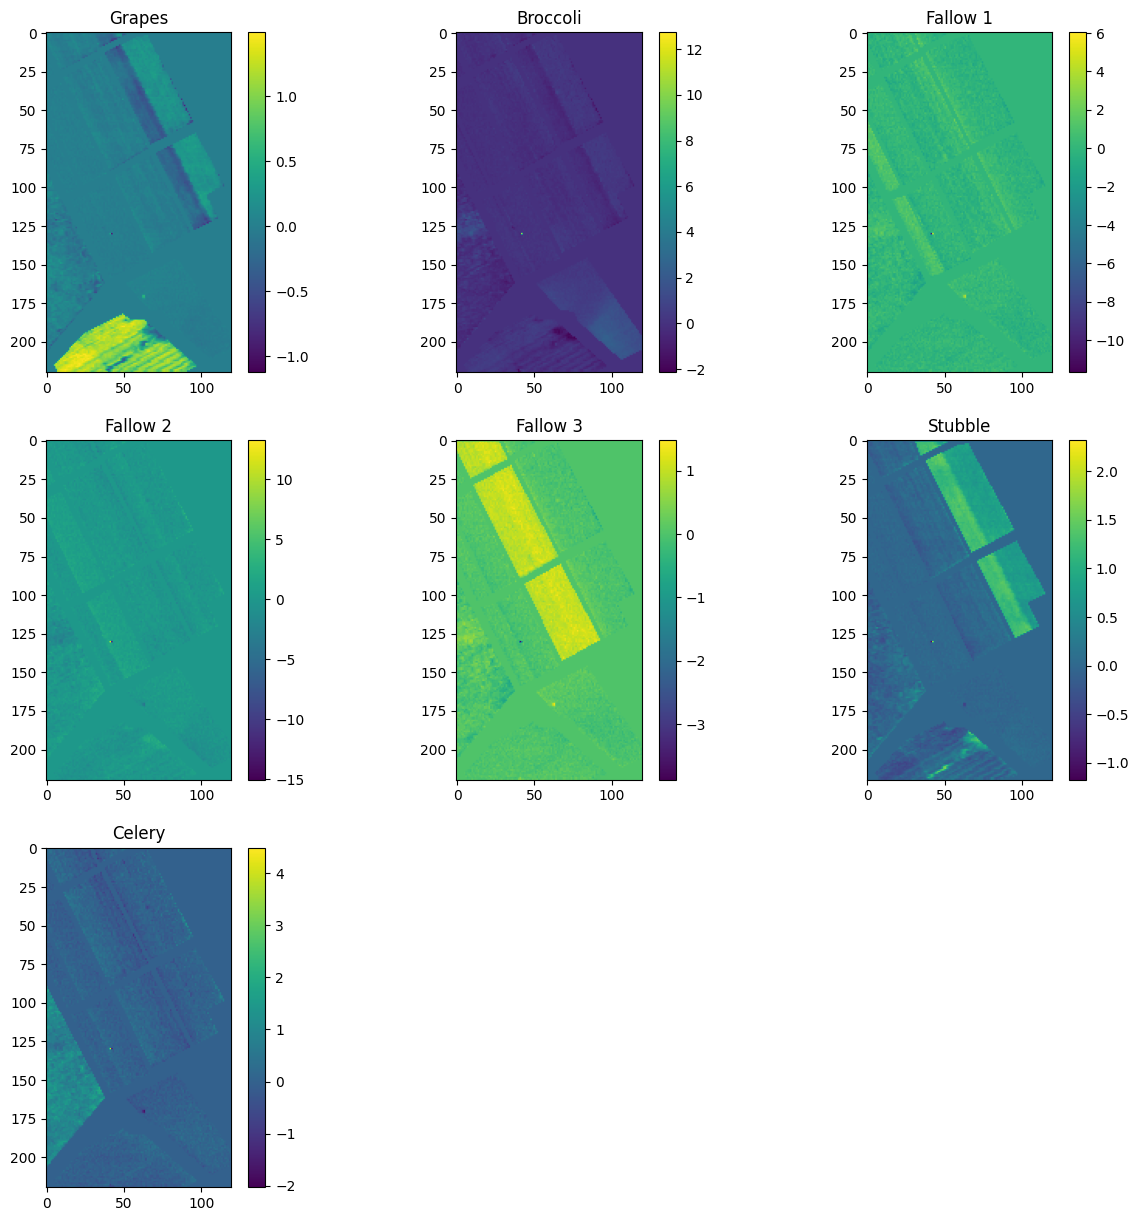

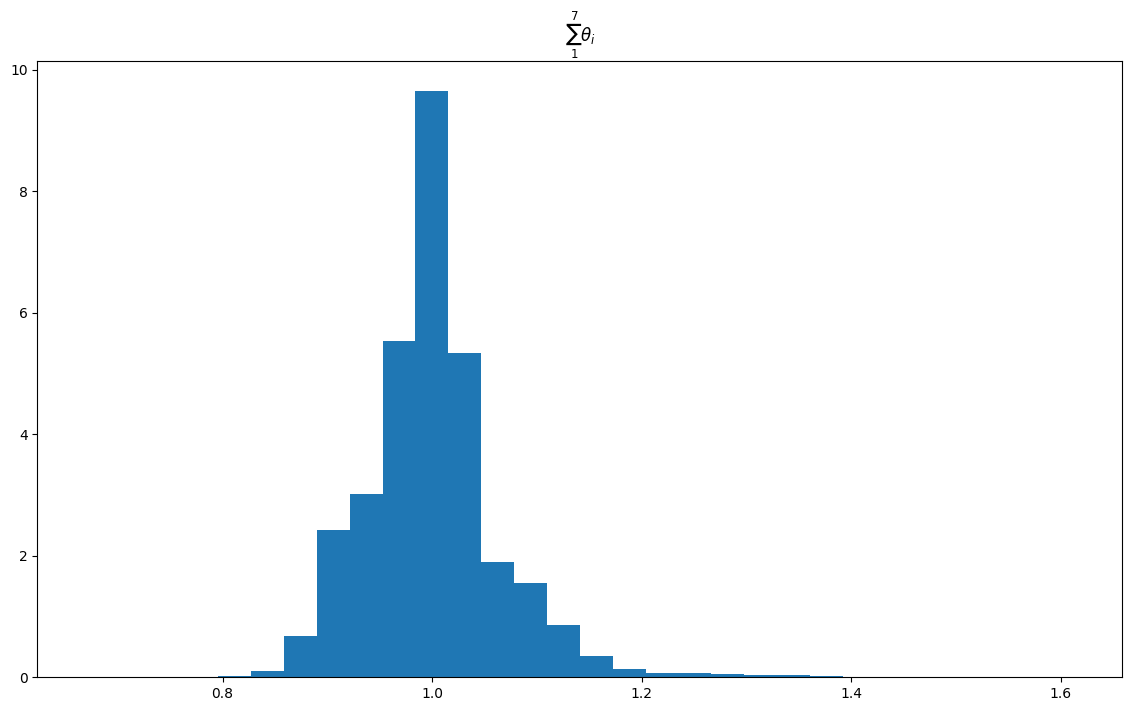

Average reconstruction error:  35058.880662772615


In [323]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels)
plot_abundance_map(abundance_map, materials)
plot_sum_of_thetas(abundance_map)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Least Square'] = round(reconstruction_error, 2)
abundance_maps['Least Squares'] = abundance_map

Average reconstruction error:  43082.57630023894


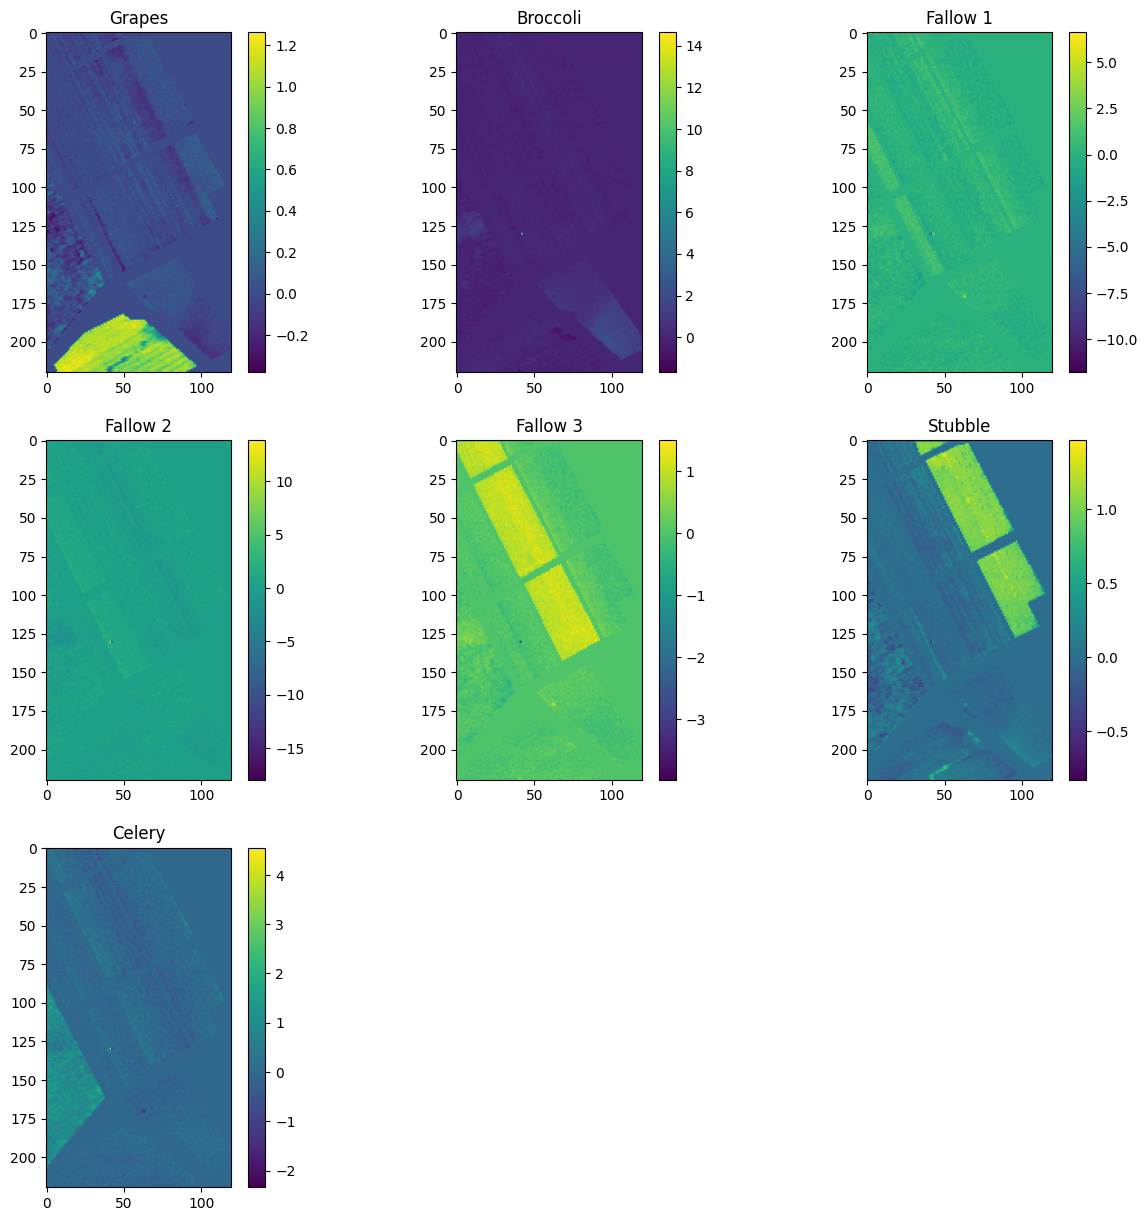

In [324]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Sum-to-One")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Sum-to-One'] = round(reconstruction_error, 2)
abundance_maps['Sum-to-One'] = abundance_map

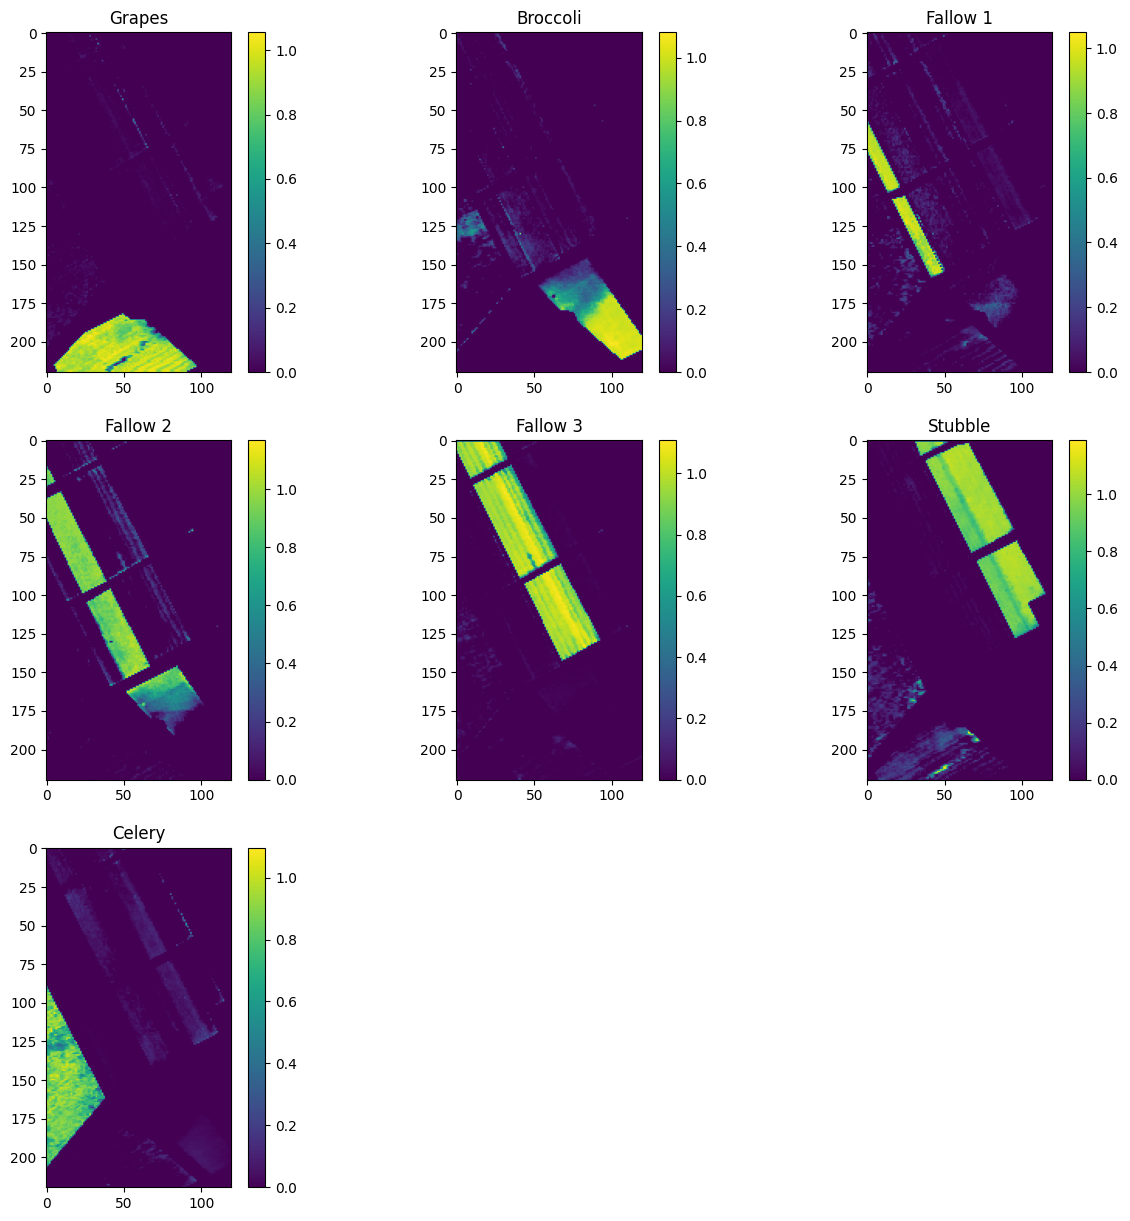

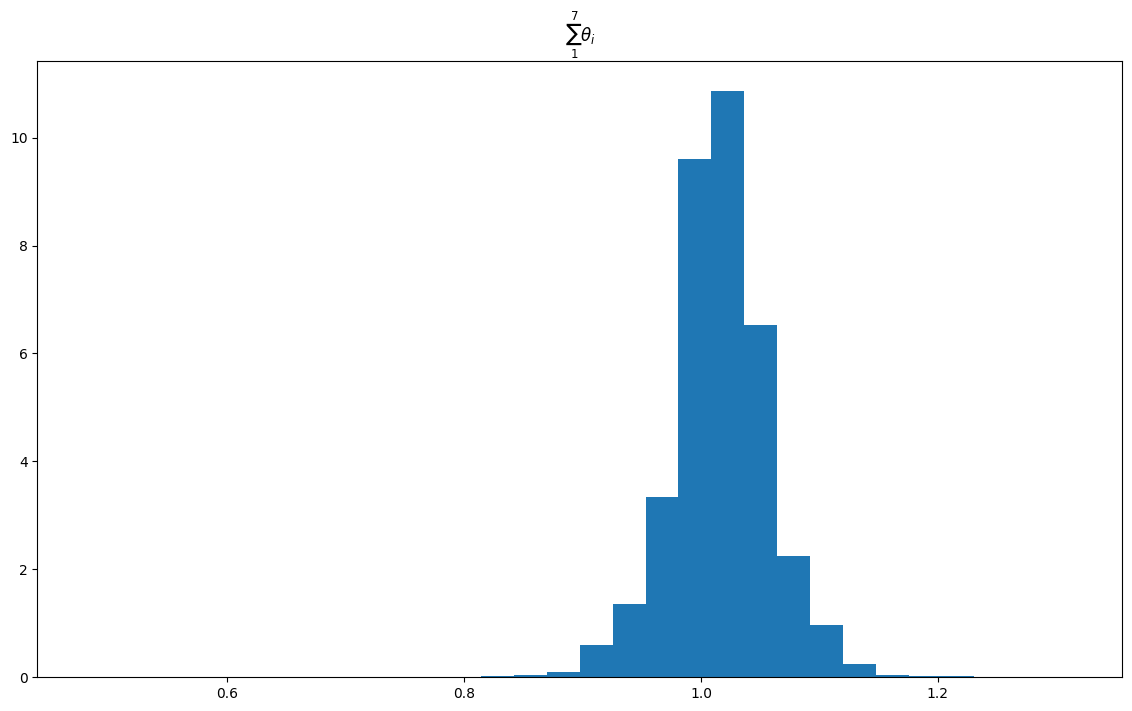

Average reconstruction error:  156104.1822064472


In [325]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative")
plot_abundance_map(abundance_map, materials)
plot_sum_of_thetas(abundance_map)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative'] = round(reconstruction_error, 2)
abundance_maps['Non-Negative'] = abundance_map

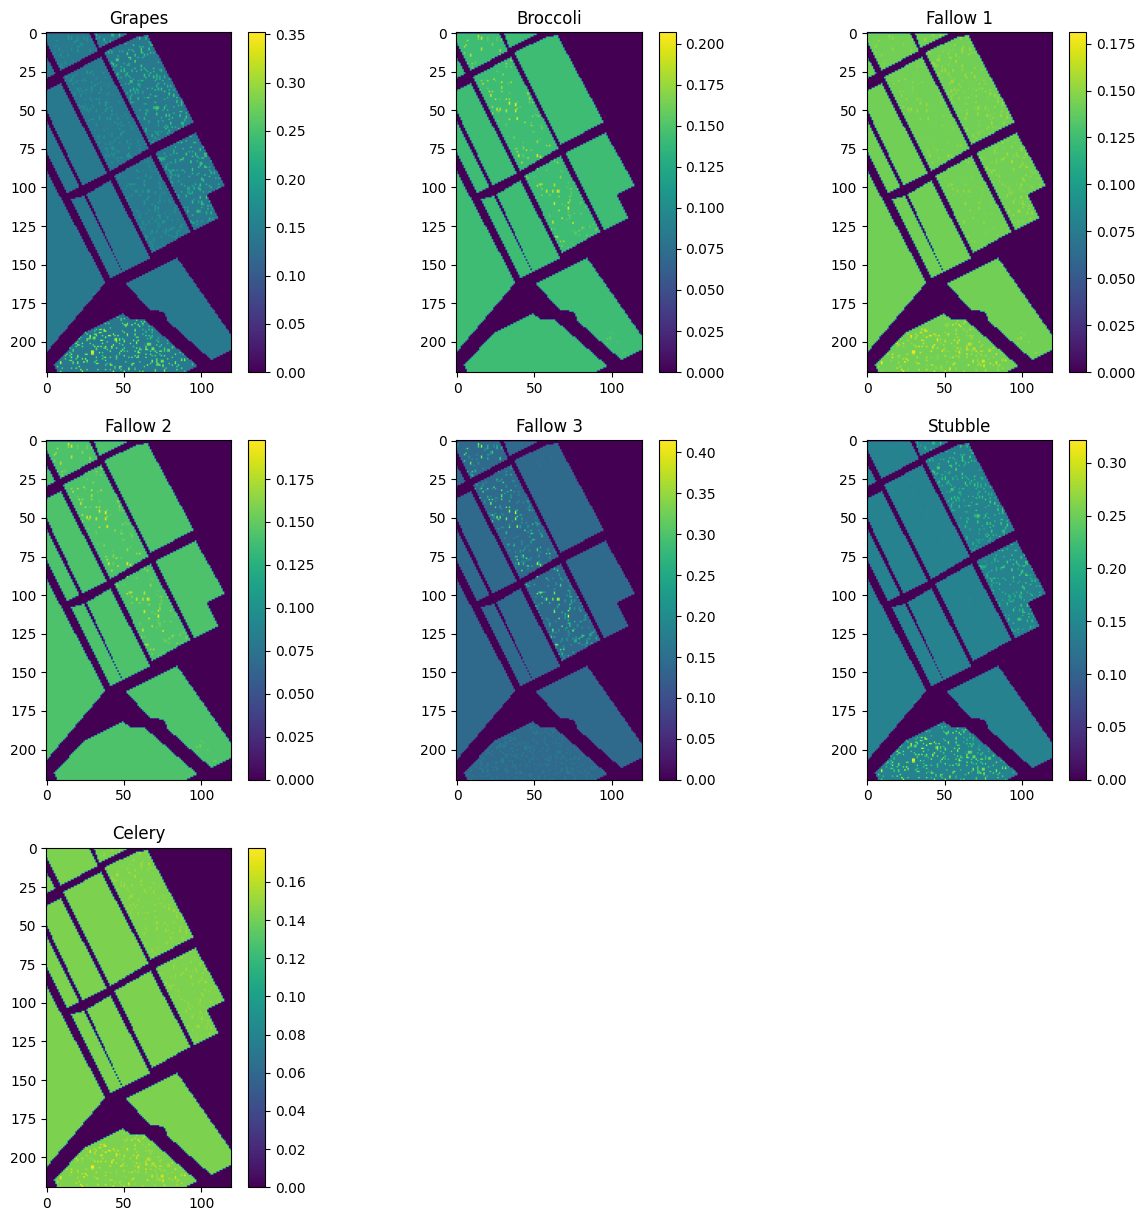

In [326]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative Sum-to-One")
plot_abundance_map(abundance_map, materials)

We can observe that the results with the Least Squares fully constrained are not ideal, so we will try again using `cvxopt` library to compare the results.

Average reconstruction error:  738727.390922355


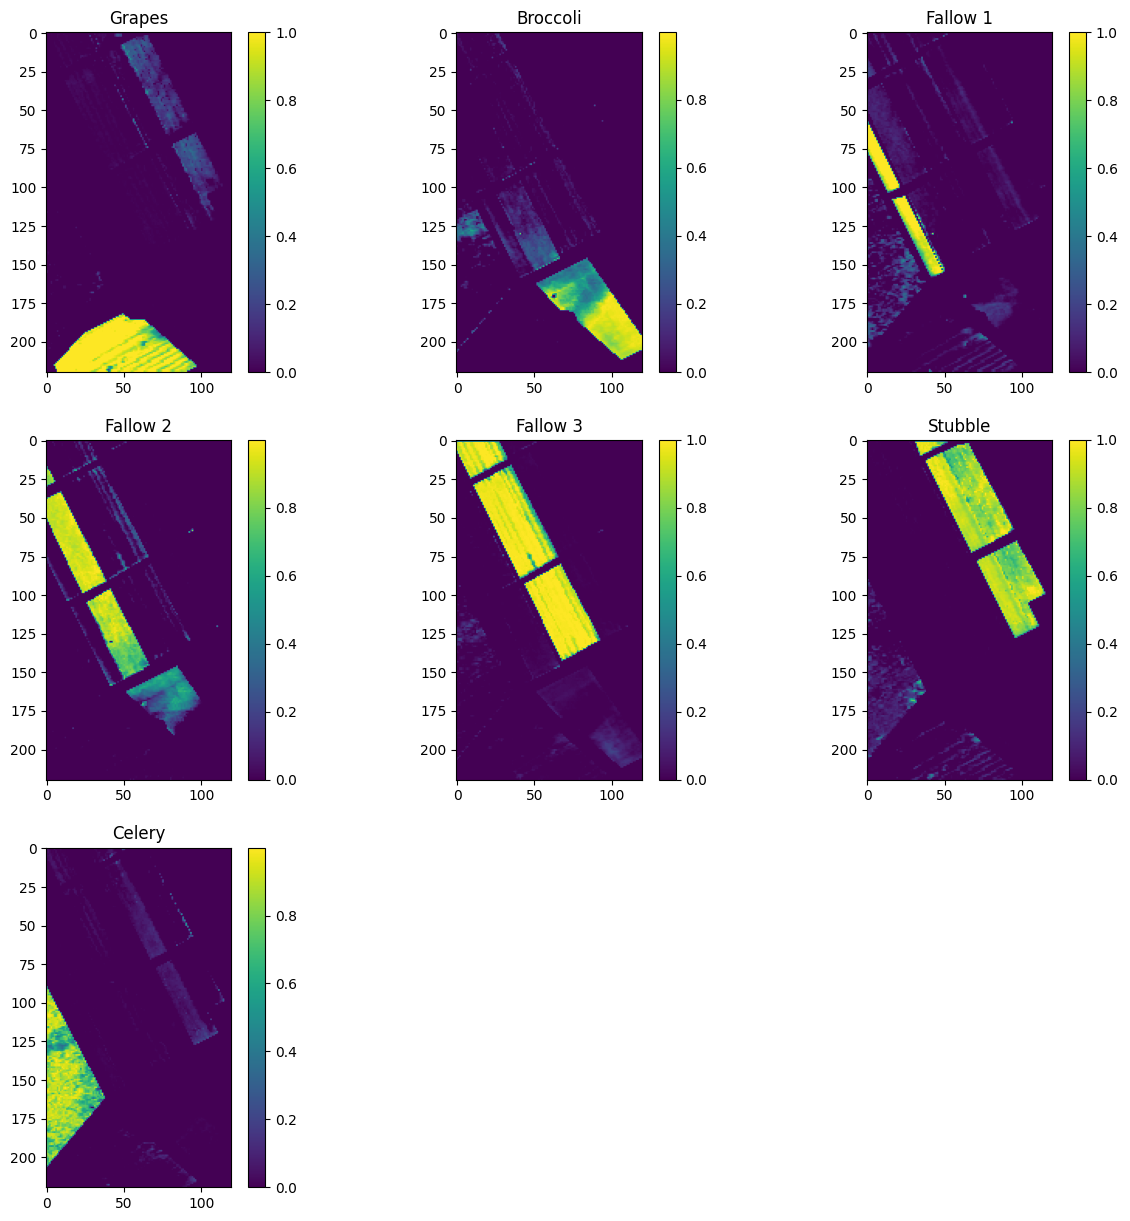

In [327]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative Sum-to-One v2")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative Sum-to-One'] = round(reconstruction_error, 2)
abundance_maps['Non-Negative Sum-to-One'] = abundance_map

Average reconstruction error:  158097.3867032992


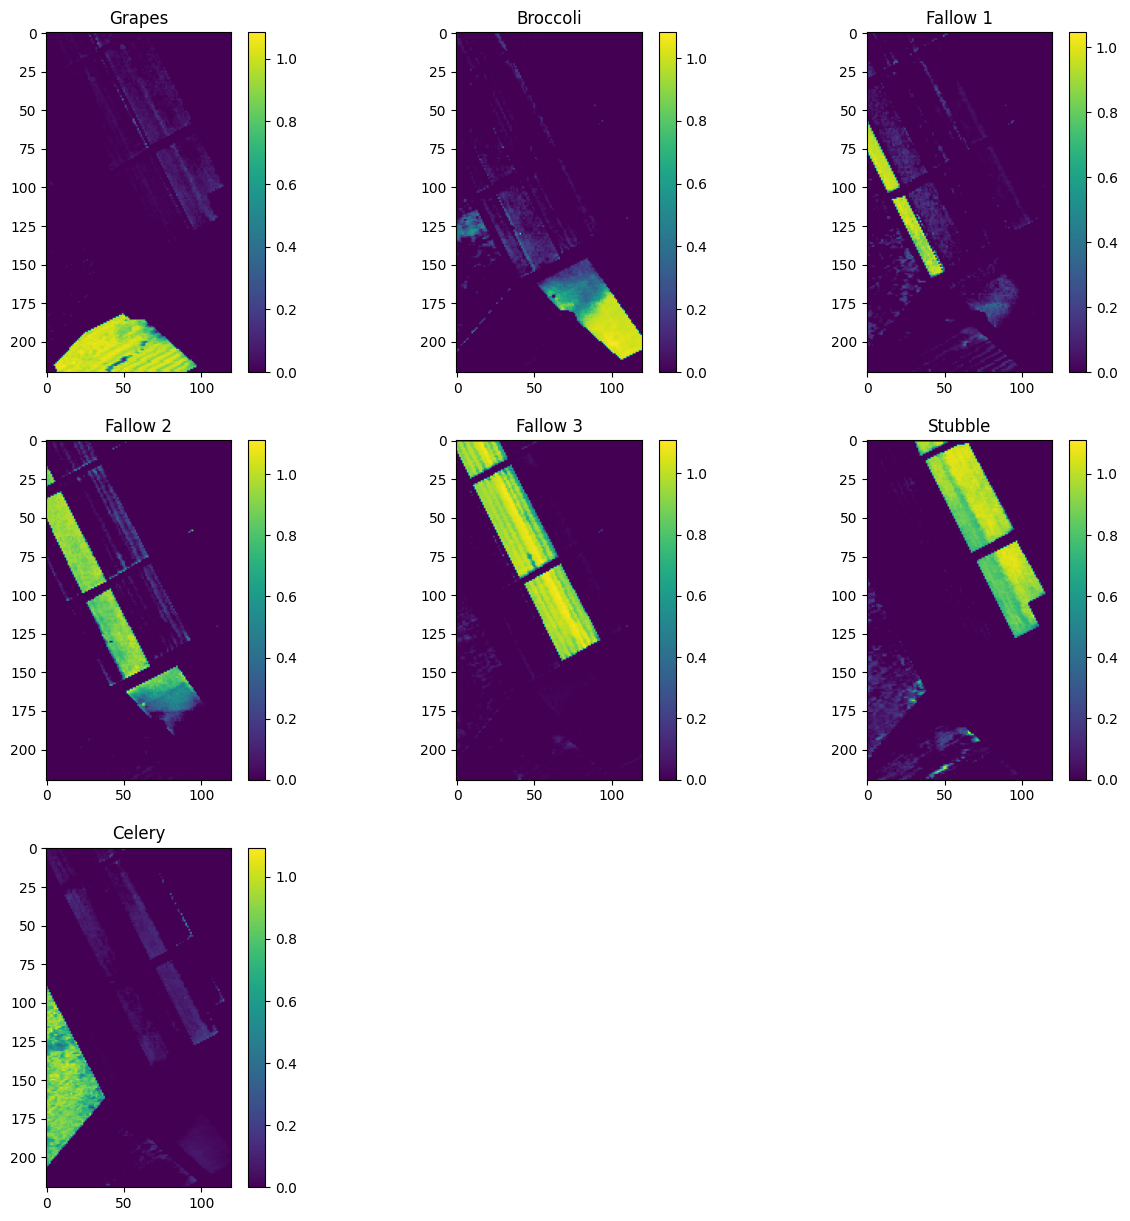

In [351]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Lasso")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Lasso'] = reconstruction_error
abundance_maps['Lasso'] = abundance_map

In [352]:
errors_df

Least Square  Sum-to-One  Non-Negative  Non-Negative Sum-to-One   
0      35058.88    43082.58     156104.18                738727.39  \

           Lasso  
0  158097.386703

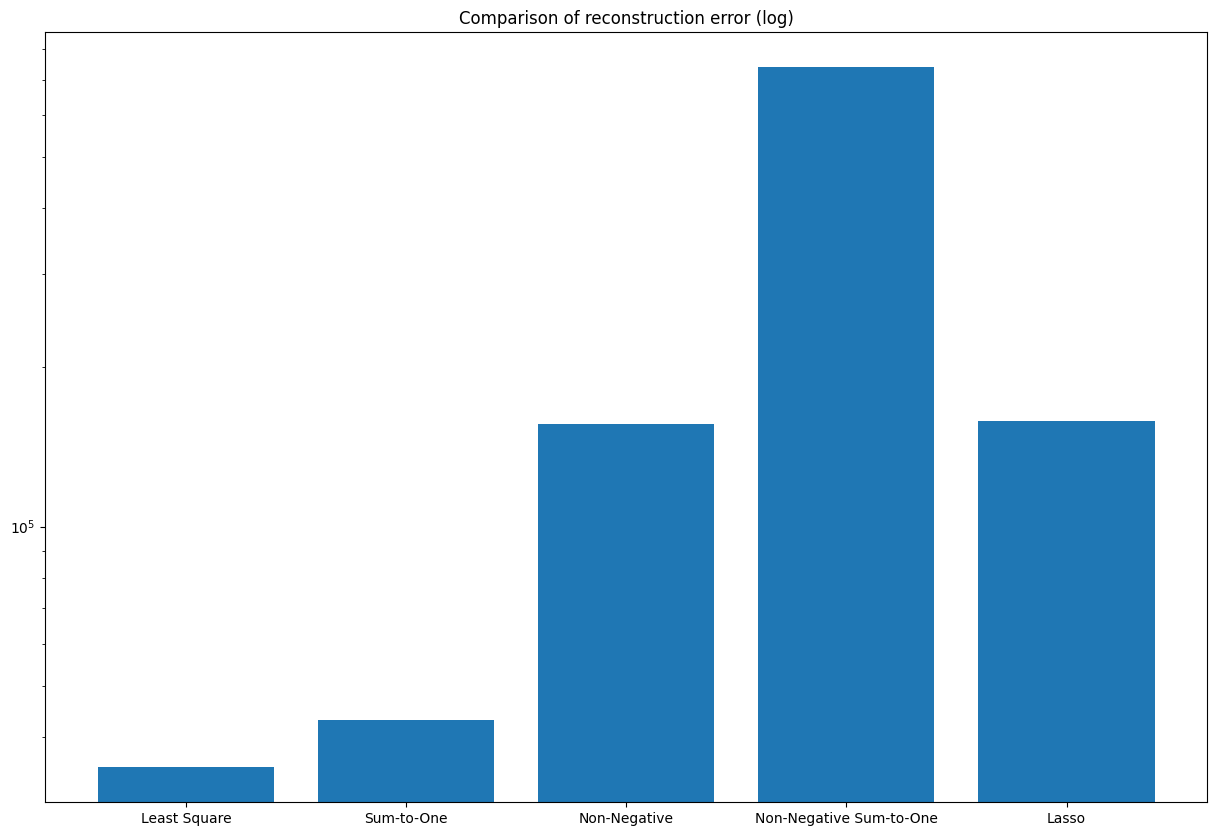

In [355]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)

ax.set_title('Comparison of reconstruction error (log)')

ax.bar(errors_df.columns, errors_df.loc[0], align='center')
ax.set_yscale('log')

plt.show()

The `Average reconstruction errors` reveal the impact of different constraints in spectral unmixing methods:
  * The **Least squares method**:
    * Achieves the lowest reconstruction error
    * Lacks physical constraints
    * Provides maximum mathematical flexibility
  * Enforcing **sum-to-one**:
    * Slightly increases error compared to basic least squares
    * Introduces a physical constraint ensuring abundance sum to /(100%)
    * Minimal impact on reconstruction accuracy
  * Enforcing **non-negativity**:
    * Significantly increases reconstruction error
    * Reflects the challenges of introducing inequality constraints
    * Reduces optimization flexibility while enforcing physically meaningful non-negative abundances
  * The combination of **sum-to-one and non-negativity**:
    * Produces the highest reconstruction error
    * Combines two restrictive constraints
    * Demonstrates that over-constraining the problem can substantially degrade reconstruction quality
  * The **LASSO (Sparce Unmixing)**:
    * Yields a relatively high reconstruction error
    * Enforces sparsity through L1 regularization
    * Suggests that while sparsity can provide insights, it may compromise overall spectral reconstruction.

`Key Insights`
  * Constraints trade mathematical flexibility for physical interpretability
  * Each constraint incrementally increases reconstruction error
  * The most physical constrained method shows the most significant accuracy degradation
  * The choice of unmixing method involves a critical balance btween mathematical precision and physical constraint

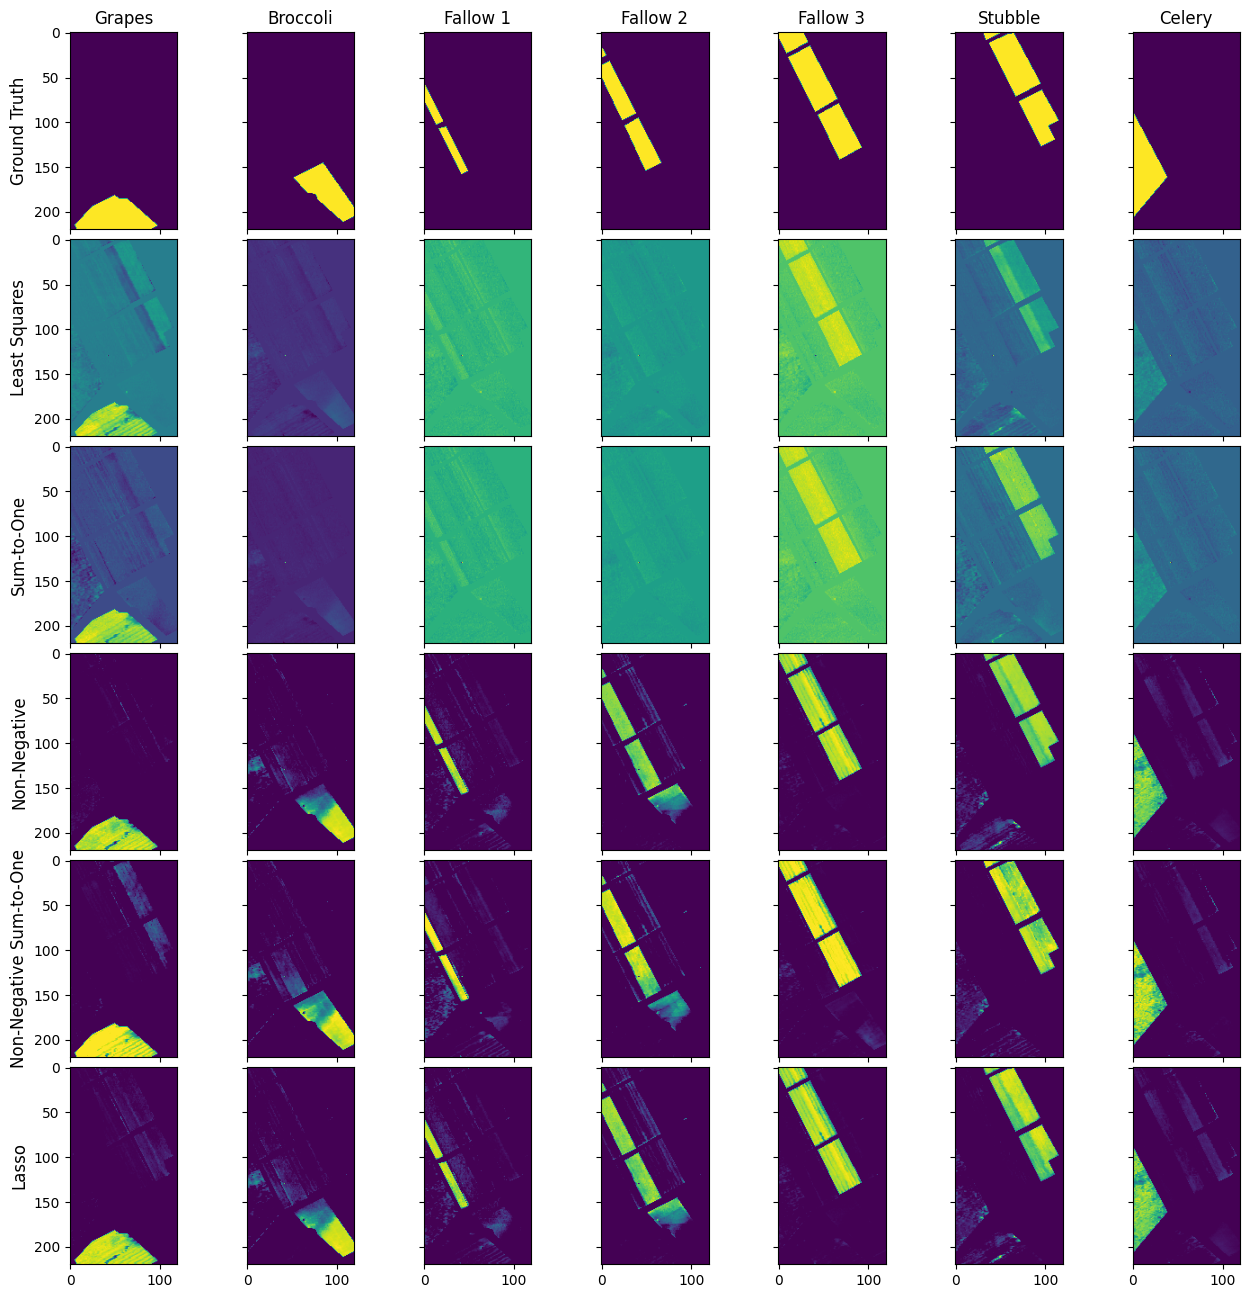

In [354]:
plot_maps_and_ground_truth(abundance_maps, materials, methods)

Regarding the abundance maps:

  * All methods effectively separated the materials to a reasonable extent.
  * When compared to the ground truth, the material assignments were accurate, with no mismatches.
  * The non-negativity-only LS and LASSO methods produced highly contrastive abundance maps with well-defined geographical boundaries. However, they performed worse in terms of reconstruction error compared to sum-to-one and unconstrained approaches. This is expected, as both methods impose restrictions (e.g., LASSO’s sparsity constraint), which tend to amplify the estimation process.

## Classification

In [331]:
# Method that prepares the data for clustering
def prepare_data_for_clustering(set, salinas_cube):
  # Keep only the important labels
  set_mask = set != 0

  # Get class labels
  y =  set[set_mask]

  # Get spectral signatures for each labeled pixel
  X_reshaped = salinas_cube.reshape(salinas_cube.shape[0] * salinas_cube.shape[1], salinas_cube.shape[2])
  X = X_reshaped[set_mask.flatten()]

  return X, y


In order to implement a `minimum Euclidean distance classifier` from scratch, we will only subclass BaseEstimator of scikit-learn library, to expose the familiar `fit/predict` API.

In [ ]:
class MinEuclideanDistanceClassifier(BaseEstimator):
    def __init__(self):
        self.classes_num = None
        self.classes_mean = None
    
    def __str__(self):
        return "Bayes classifier"
    
    @staticmethod
    def euclidean_distance(arr1, arr2):
        diff = arr1 - arr2
        
        return np.dot(diff, diff)
        
    def fit(self, X, y):
        
        self.classes_num = len(np.unique(y))
        
        m, n = X.shape
        
        self.classes_mean = np.zeros((self.classes_num, n))
        
        for i in range(self.classes_num):
            
            self.classes_mean[i] = np.mean(X[y == i + 1], axis=0)
        
        return self
    
    def predict(self, X):
        
        m, _ = X.shape
        
        y_pred = np.zeros(m)
        
        if self.classes_num is None:
            raise ValueError("fit() was not called before predict() - aborting.")
        
        for i in range(m):
            
            dist = np.zeros(self.classes_num)
            
            for j in range(self.classes_num):
                
                dist[j] = self.euclidean_distance(X[i], self.classes_mean[j])
                
            y_pred[i] = np.argmin(dist) + 1.0
            
        return y_pred

In [338]:
# Method that implements a mis-classification error
def error(predictions, gold):
    return 1 - np.sum((predictions == gold)) / len(gold)


In [339]:
# Method that performs 10-fold cross-validation
def evaluate_with_cross_validation(clf, X_train, y_train):
    cv_errors = 1 - cross_val_score(clf, X_train, y_train, cv=10, scoring=make_scorer(error))

    mean_valid_error = cv_errors.mean()
    standard_deviation = cv_errors.std()

    return mean_valid_error, standard_deviation

In [334]:
# Method that evaluates the classifier on the test set
def evaluate_on_test_set(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    conf_matrix_array = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(
        conf_matrix_array, 
        columns=[materials.get(i) for i in range(1, 8)], 
        index=[materials.get(i) for i in range(1, 8)])
        
    success_rate = np.trace(conf_matrix) / np.sum(conf_matrix.values)    
    
    # Identify poorly separated classes using DataFrame operations
    poor_separation = []
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i != j and conf_matrix.iloc[i, j] > 1:  # Use `.iloc` for DataFrame access
                poor_separation.append((conf_matrix.index[i], conf_matrix.columns[j], conf_matrix.iloc[i, j]))
    
    return conf_matrix, success_rate, poor_separation

In [335]:
# This method will evaluate a classifier given using cross-validation and on the test set
def produce_classification_results(clf, X_train, y_train, X_test, y_test):
    best_success_rate = 0

    # 1. Cross-validation
    mean_valid_error, standard_deviation = evaluate_with_cross_validation(clf, X_train, y_train)

    # 2. Test set evaluation
    conf_matrix, success_rate, poor_separation = evaluate_on_test_set(clf, X_train, X_test, y_train, y_test)

    # Track best classifier
    if success_rate > best_success_rate:
        best_success_rate = success_rate

    return mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation


In [336]:
classifiers = {
    'min_distance': MinEuclideanDistanceClassifier(),
    'naive_bayes': GaussianNB(),
    'k_nearest': KNeighborsClassifier(n_neighbors=5),
    'bayesian': QuadraticDiscriminantAnalysis()
}

X_train, y_train = prepare_data_for_clustering(Training_Set, HSI)
X_test, y_test = prepare_data_for_clustering(Test_Set, HSI)

results = pd.DataFrame(columns=['Classifier', 'Mean validation error', 'Standard deviation', 'Success rate'])

In [342]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('min_distance'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)

if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[0] = ['Minimum distance', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       536         0         4         0         1        0       7
Broccoli       2       484         0         0         0        0      31
Fallow 1       0         0       417         0        95        0       0
Fallow 2       0         0         0       212         2        0       0
Fallow 3       0         0        16         4       543        0       0
Stubble        0         0         6         0         0      992       0
Celery         5         0         0         0         0        0     875

Poorly separated classes:
Class Grapes confused with Class Fallow 1 (4 pixels)
Class Grapes confused with Class Celery (7 pixels)
Class Broccoli confused with Class Grapes (2 pixels)
Class Broccoli confused with Class Celery (31 pixels)
Class Fallow 1 confused with Class Fallow 3 (95 pixels)
Class Fallow 2 confused with Class Fallow 3 (2 pixels)
Class Fallow 3 confused with Class Fallow 1 (16 pixels)
Cla

The `Minimum Distance Classifier` works by assigning a pixel to the class with the nearest ceontroid using Euclidean distance. Its performance shows:
  * Major confusion between Broccoli and Fallow 2 (95 pixels); this suggests these classes have similar spectral signatures with centroids relatively close to each other.
  * Notable confusion between Grapes and Stubble (31 pixels); these materials likely have overlapping spectral characteristics.

In [343]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('naive_bayes'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)
    
if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[1] = ['Naive Bayes', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       545         0         0         0         0        0       3
Broccoli       5       512         0         0         0        0       0
Fallow 1       0         0       470         0        42        0       0
Fallow 2       0         0         0       210         4        0       0
Fallow 3       0         0        12         4       547        0       0
Stubble        1         0         2         0         0      995       0
Celery         6         0         0         0         0        0     874

Poorly separated classes:
Class Grapes confused with Class Celery (3 pixels)
Class Broccoli confused with Class Grapes (5 pixels)
Class Fallow 1 confused with Class Fallow 3 (42 pixels)
Class Fallow 2 confused with Class Fallow 3 (4 pixels)
Class Fallow 3 confused with Class Fallow 1 (12 pixels)
Class Fallow 3 confused with Class Fallow 2 (4 pixels)
Class Stubble confused with Class Fallow 1 (2 pixels)
C

The `Naive Bayes Classifier` assumes feature independence and uses probability distributions:
  * It has overall better separation than the Minimum Distance Classifier.
  * It still shows confusion between Brocolli and Fallow 2 (42 pixels), but less than the minimum distance.
  * The assumption of feature independence works well here, suggesting the spectral bands contain relatively independent information.
  * It is generally more accurate with spectrally distinct classes.

In [344]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('k_nearest'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)
    
if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[2] = ['k-Nearest', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       547         0         0         0         0        0       1
Broccoli       0       516         0         0         0        0       1
Fallow 1       0         0       510         0         2        0       0
Fallow 2       0         0         0       213         1        0       0
Fallow 3       0         0         8         1       552        2       0
Stubble        0         0         0         0         0      998       0
Celery         0         1         0         0         0        0     879

Poorly separated classes:
Class Fallow 1 confused with Class Fallow 3 (2 pixels)
Class Fallow 3 confused with Class Fallow 1 (8 pixels)
Class Fallow 3 confused with Class Stubble (2 pixels)


The `K-Nearest Neigbor Classifier` is the best performing classifier:
  * We have almost perfect separation between classes.
  * Minimal confusion between classes (only 13 misclassifier pixels total).

The **superior performance** is derives from the fact that:
  * It considers local neighborhood structure.
  * Doesn't make assumptions about the data distribution.
  * Can handle complex decision boundaries.
  * Works well with the high-dimensional nature of hyperspectral data.

In [345]:
mean_valid_error, standard_deviation, conf_matrix, success_rate, poor_separation = produce_classification_results(
      classifiers.get('bayesian'), 
      X_train, 
      y_train, 
      X_test, 
      y_test)

print(conf_matrix)

if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")

results.loc[3] = ['Bayesian', mean_valid_error, standard_deviation, success_rate]

          Grapes  Broccoli  Fallow 1  Fallow 2  Fallow 3  Stubble  Celery
Grapes       548         0         0         0         0        0       0
Broccoli       0       517         0         0         0        0       0
Fallow 1       0         0       512         0         0        0       0
Fallow 2       0         0         0       125        89        0       0
Fallow 3       0         0         3         0       558        2       0
Stubble        0         0         0         0         0      998       0
Celery         0         0         0         0         0        0     880

Poorly separated classes:
Class Fallow 2 confused with Class Fallow 3 (89 pixels)
Class Fallow 3 confused with Class Fallow 1 (3 pixels)
Class Fallow 3 confused with Class Stubble (2 pixels)


The `Bayesian Classifier` shows perfect classification for many classes. Its main confusion occurs between:
  * Fallow 2 and Fallow 3: 89 pixels from Fallow 2 were masclassifier as Fallow 3.
  * Minor confusion with Fallow 3 class: 3 pixels misclassified as Fallow 1 and 2 pixels as Stubble.

In [346]:
results

Classifier  Mean validation error  Standard deviation  Success rate
0  Minimum distance               0.944925            0.076824      0.959121
1       Naive Bayes               0.973776            0.016023      0.981333
2         k-Nearest               0.989838            0.014536      0.995983
3          Bayesian               0.965739            0.005851      0.977788

The classification results show the same exact patters between each Classifier as mentioned above:
  * The `Minimum Distance Classifier`:
    1. Has the lowest success rate, highest mean validation error and the highest standard deviation.
    2. This indicates that:
      * It is the least reliable classifier overall.
      * The most unstable performance across different validation folds.
      * The simple distance-based approach struggles with complex spectral patterns.
      * Its performance depends on the specific data split.
  * The `Naive Bayes Classifier`:
    1. Has the second best success rate, moderate mean validation errror and moderate standard deviation.
    2. This suggests:
      * Very good performance despite simple assumptions.
      * Reasonably stable across different data splits.
      * Feature independence assumption works well for this data.
      * Good balance between model simplicity and performance.
  * The `k-Nearest Neigbor`:
    1. Has the best success rate, lowest mean validation error and low standard deviation.
    2. This shows:
      * Most accurate classifier by a significant margin.
      * Most consistent in terms of error rate.
      * Local neigbourhood approach works exceptionally well.
      * Best at handling the complex spectral relationships.
  * The `Bayesian`:
    1. Has the third best success rate, third best mean validation error and the lowest standard deviation.
    2. This indicates:
      * Most stable classifier across validation folds.
      * Good but not top performance.
      * Full covariance modeling provides stability.
      * Slightly less accurate than simpler Naive-Bayes.

In [347]:
# Method that evaluates the classifier on the operational set
def evaluate_classifier_operational(clf, X_operational, y_operational, classes):
    # Make predictions on operational set
    y_pred = clf.predict(X_operational)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_operational, y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_operational, y_pred)
    
    # Calculate per-class accuracy
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    
    # Generate classification report
    report = classification_report(y_operational, y_pred, 
                                target_names=classes if classes else None,
                                output_dict=True)
    
    # Return all metrics in a dictionary
    return {
        'accuracy': accuracy,
        'per_class_accuracy': per_class_accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'predictions': y_pred
    }

In [348]:
X_operational, y_operational = prepare_data_for_clustering(Operational_Set, HSI)

In [349]:
results = evaluate_classifier_operational(classifiers.get('k_nearest'), X_operational, y_operational, materials)

# Print overall accuracy
print("\n=== Overall Accuracy ===")
print(f"{results['accuracy']*100:.2f}%")

# Print per-class accuracy
print("\n=== Per-Class Accuracy ===")
for i, acc in enumerate(results['per_class_accuracy']):
    print(f"{materials.get(i)}: {acc*100:.2f}%")

# Print confusion matrix
print("\n=== Confusion Matrix ===")
print("\nActual vs Predicted:")
for i, row in enumerate(results['confusion_matrix']):
    print(f"{materials.get(i)}: {row}")

print("\n=== Detailed Metrics per Class ===")
for class_num, class_name in materials.items():
    metrics = results['classification_report'][class_num]  # Use the class number directly
    print(f"\n{class_name}:")
    print(f"Precision: {metrics['precision']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"F1-score: {metrics['f1-score']*100:.2f}%")
    print(f"Support: {int(metrics['support'])} samples")


=== Overall Accuracy ===
99.55%

=== Per-Class Accuracy ===
None: 99.83%
Grapes: 99.82%
Broccoli: 99.35%
Fallow 1: 98.96%
Fallow 2: 98.05%
Fallow 3: 100.00%
Stubble: 99.78%

=== Confusion Matrix ===

Actual vs Predicted:
None: [599   0   0   0   0   0   1]
Grapes: [  1 568   0   0   0   0   0]
Broccoli: [  0   0 459   2   1   0   0]
Fallow 1: [  0   0   0 190   2   0   0]
Fallow 2: [  0   0   8   2 504   0   0]
Fallow 3: [  0   0   0   0   0 988   0]
Stubble: [  2   0   0   0   0   0 905]

=== Detailed Metrics per Class ===

Grapes:
Precision: 99.50%
Recall: 99.83%
F1-score: 99.67%
Support: 600 samples

Broccoli:
Precision: 100.00%
Recall: 99.82%
F1-score: 99.91%
Support: 569 samples

Fallow 1:
Precision: 98.29%
Recall: 99.35%
F1-score: 98.82%
Support: 462 samples

Fallow 2:
Precision: 97.94%
Recall: 98.96%
F1-score: 98.45%
Support: 192 samples

Fallow 3:
Precision: 99.41%
Recall: 98.05%
F1-score: 98.73%
Support: 514 samples

Stubble:
Precision: 100.00%
Recall: 100.00%
F1-score: 100.0

The k-Nearest Neighbors classifier delivered excellent results, even with the operational data, further supporting that it is the most suitable choice for this problem's data.

## Combination

In the classification results, a consistent pattern was observed, where all classifiers showed a slight tendency to misclassify material Fallow 3. However, there doesn't seem to be any issue with the spectral unmixing task for Fallow 3. This could be because materials Fallow 1, Fallow 2, Fallow 3, and Stubble are all land fields located in close proximity to each other. As a result, unmixing their spectral signatures may be an easier task compared to classifying their respective image pixels.